# Assessed Exercise for Deep Learning (M)

This exercise must be submitted as a colab notebook. Deadline  Monday the 4th of March, 15:00.





You will create a classifier and test it on a collection of images for a new task. While you are welcome to build a full network from scratch, most of you will not have sufficient access to the data and compuational power required, so you are welcome to provide a solution based on transfer learning from a pre-trained network, adapted to your new task. 

The Keras documentation has some examples of pretrained networks which are easy to integrate, see for example  their ResNet50 example [https://keras.io/applications/#classify-imagenet-classes-with-resnet50](https://keras.io/applications/#classify-imagenet-classes-with-resnet50), or the InceptionV3 network  [https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes). If you use the pretrained model, a good way to start is by freezing all layers up to the last layer before the output. Adapt the output layer to fit your classification problem. You might then unfreeze some earlier layers for further fine tuning.

You will need to create a training set (at least 100 images per class, potentially classifying e.g type of location, activity. If you are training a full network from scratch you would need orders of magnitude more, but this will work for transfer learning on an existing network). It might be sensible to start off testing and demonstrating your approach by using an existing dataset e.g. 
the [flowers one](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/). You can find other interesting datasets at:
*   [http://deeplearning.net/datasets](http://deeplearning.net/datasets/)  
*   [UCI ML collection](https://archive.ics.uci.edu/ml/datasets.html)
*   [https://www.visualdata.io](https://www.visualdata.io)
*   [https://ai.google/tools/datasets](https://ai.google/tools/datasets/ )

Students who put more effort into creating and analysing an interesting dataset will tend to do better in marks for sections 1. & 2. below.

Write a pre-processing step that will resize and crop the images to the right size ((224, 224) is default for ResNet50 and (299,299) is the default for Inception), and consider how you can apply data augmentation techniques to your new dataset, and design appropriate pre-processing functions.

In your submission you should have the following structure (share of the AX marks given in brackets at the end of each part):

1.   Analysis of the problem. (15%)
2.   Visualisation and analysis of the data type, quality and  class distributions. You may want to design some data augmentation in your system. (20%)
3.   Creation of multiple candidate network architectures. Include your justification of the design decisions. You should inlcude one very simple baseline model (e.g. a linear model, or a simple two layer Densely connected model). (15%)
4.   Training. This should include code for hyperparameter search, regularisation methods. (15%)
5.   Empirical evaluation of performance, and potentially visualisation and  analysis of the trained network. This should make good use of graphs and tables of results, confusion matrices etc to represent the relative performance of the different models.  Explain why you chose the metrics you use. (20%)
6.   Report on the performance, discussing the suitability of the final network for use. (15%)

For each of the design decisions, make sure you describe in detail the motivation behind them. 

**Submission process**

You should submit the colab notebook with *all* code needed to run your model and all visualisations of results in place (I don't want to have to run 80 projects :-) ). This exercise must be submitted as a colab notebook. Deadline Monday the 4th of March, 15:00. If you have your own training data, make sure that any links to that are accessible by 3rd parties (me - I won't share the links with anyone else).

Share the Colab link (click on Share on top right of the Colab notebook, then 'Get shareable link') with me by e-mail [Roderick.Murray-Smith@glasgow.ac.uk](mailto:Roderick.Murray-Smith@glasgow.ac.uk?subject=Deep Learning AX 2019) and make sure that the Subject of the e-mail is *exactly* `'Deep Learning AX 2019'` (automatically generated if you click on the e-mail hyperlink above)

# Some code snippets which might be useful to get you started

In [29]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

Using TensorFlow backend.


# Additional Notebook Setup

## Google Drive Mounting

The following cell mounts the Google Drive where data is stored and sets the 'BASE_PATH' variable which points to this project.

In [30]:
path = os.getcwd()
BASE_PATH = "" # set manually if not using CoLab
print(path)
if path == '/content' or path == '/content/gdrive/My Drive/building_classifier':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/building_classifier/'
    os.chdir('/content/gdrive/My Drive/building_classifier/')
    
else:
    print("Please set BASE_PATH manually")

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/building_classifier
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports

In [0]:
# Image Processing
import glob
import cv2
from skimage.transform import resize

# Deep copying
from copy import deepcopy

# For custom DataGenerator
from keras.utils import Sequence, to_categorical

# For making sequantial models
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D

# Introduction

The aim of this project is to develop a classifier to identify buildings from the University of Glasgow. Such a model could then be embedded into a smartphone app to help navigation for new students at the University.


# The Datset

For the dataset, six buildings were chosen:


*   Boyd Orr
*   Adam Smith
*   Rankine
*   James Watt (South)
*   Main Building
*   Reading Room

To generate the large number of images needed to train the models, videos were taken of the buildings. From the videos, the indiviudal frames were used to form the dataset.

The dataset was collected from four days of filming. Each day, all six buildings were filmed. Four different days were chosen to provide variation in weather conditions.

The following table provides a description of the weather for each day:

Day     | Weather 
---|---
12/02/2019   | Cloudy      
14/02/2019   | Cloudy
15/02/2019  | Sunny
17/02/2019 | Cloudy w/ Sunny Intervals

When collecting videos of a building it was attempted to provide good coverage all the way round the building however due to limitations such as construction work this was not always possible.

The videos were recorded at 720p using a mobile phone with no wide angle lense.


## Image Processing
Extracting frames from videos and resizing to 224x224.

Videos are stored i nthe format: raw/'date_taken'/'building_name_number'.mp4

The extracted frames are stored in the format: processed/'date_taken'/'building_name'/'number'.png

In [0]:
TARGET_IMAGE_SHAPE = (224, 224)
TARGET_IMAGE_FORMAT = '.png'
PROCESS_VIDEOS = False # set to false to prevent accidental overwriting

In [0]:
video_folders = ["12_02_2019", "14_02_2019", "15_02_2019", "17_02_2019"]

labels = ["rankine", "james", "main", "reading", "boyd", "adam"]

In [0]:
def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [0]:
PROCESSED_PATH = BASE_PATH + 'data/processed/'
make_path(PROCESSED_PATH)

In [0]:
# assumes landscape ratio (crops images to 720x720)
def crop_to_square(image):
    height = image.shape[0]
    width_centre = image.shape[1]/2
    start_width = int(width_centre - (height/2))
    end_width = int(width_centre + (height/2))
    return image[:,start_width:end_width,:]

In [0]:
if PROCESS_VIDEOS:
    for folder in video_folders:
        print("Processing Folder:", folder)

        VIDEO_PATH = BASE_PATH + 'data/raw/' + folder
        processed_folder_path = PROCESSED_PATH + folder + "/"
        make_path(processed_folder_path)

        count = 0 # used to give images different names 
        for path in glob.glob(VIDEO_PATH + "/*.mp4"):
            split_path = path.split("/")
            file_name = split_path[-1]
            split_file_name = file_name.split('_')
            building = split_file_name[0] 
            image_folder_path = processed_folder_path + building + '/'
            make_path(image_folder_path)

            vidcap = cv2.VideoCapture(path)
            success = 1
            while success:
                success, image = vidcap.read()  
                if success:
                    image = crop_to_square(image)
                    image = resize(image, TARGET_IMAGE_SHAPE) # resize 720x720 image to 224x224
                    save_path = image_folder_path + str(count) + TARGET_IMAGE_FORMAT
                    plt.imsave(save_path, image) # save image
    #                 cv2.imwrite(save_path, image)     # save image    
                    count += 1

            print("Video Processed")

## Index File Creation
This section creates an index file.

In [0]:
picture_folders = video_folders

In [0]:
file_index = {}
for folder in picture_folders:
    file_index[folder] = {}
    for label in labels:
        file_index[folder][label] = []
        
for path in glob.glob(PROCESSED_PATH + "*/*/*.png"):
    split_path = path.split("/")
    day = split_path[-3]
    building = split_path[-2]
    file = split_path[-1]
    file_index[day][building].append(path)

## Data Analysis

In [0]:
def plot_subplot(file_index, day, axis, max_y):
    counts = {}
    for key, value in file_index[day].items():
        counts[key] = len(value)
        
    axis.bar(range(len(counts)), list(counts.values()), align='center')
    axis.set_title("Day: " + day)
    axis.set_xticks(range(len(counts)))
    axis.set_xticklabels(list(counts.keys()))
    axis.set_ylim(0, max_y)

In [0]:
def plot_day_distribution(index, picture_folders, max_y_val):
    f, axarr = plt.subplots(2, 2)
    plot_subplot(index, picture_folders[0] , axarr[0, 0], max_y_val)
    plot_subplot(index, picture_folders[1] , axarr[0, 1], max_y_val)
    plot_subplot(index, picture_folders[2] , axarr[1, 0], max_y_val)
    plot_subplot(index, picture_folders[3] , axarr[1, 1], max_y_val)

    for ax in axarr.flat:
        ax.set(xlabel='Building', ylabel='Number of Pictures')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()


In [0]:
max_y_val = 0
for folder in file_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

### Figure 1: Picture Distribution per Day per Class

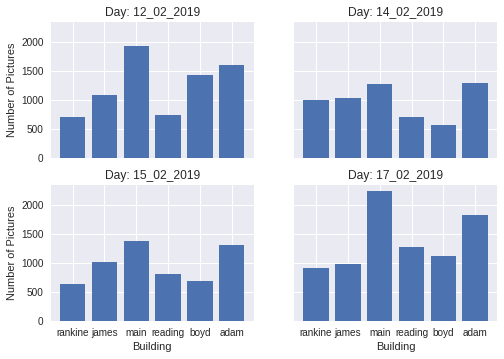

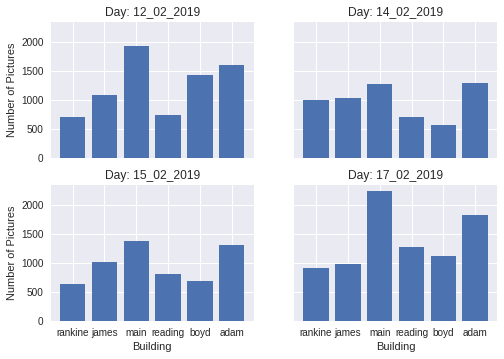

In [43]:
plot_day_distribution(file_index, picture_folders, max_y_val)

### Number of pictures per class (total)

In [0]:
def plot_total_distribution(index):
    type_counts = {
        "boyd": 0,
        "adam": 0,
        "reading": 0,
        "main": 0,
        "james": 0,
        "main": 0,
        "rankine": 0
    }
    
    for folder in index.values():
        for label, count in folder.items():
            type_counts[label] += len(count)
    
    plt.bar(range(len(type_counts)), list(type_counts.values()), align='center')
    plt.title("Total Pictures per Class")
    plt.xticks(range(len(type_counts)), list(type_counts.keys()))

### Figure 2: Total Pictures per Class

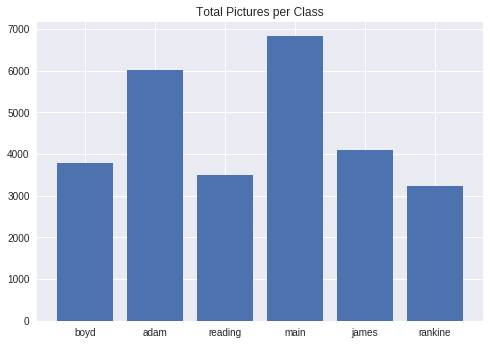

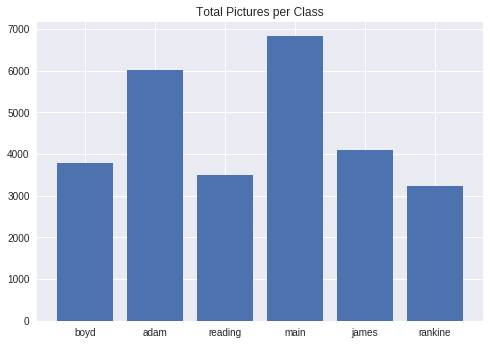

In [45]:
plot_total_distribution(file_index)

Figures 1 and 2 show that there is a clear class imbalance between the buildings. The Adam Smith building and the University Main building have significantly more images (almost double). If the model were to be trained directly on this data then it would be biased towards the Adam Smith and Main buildings.

Figure 1 shows that there is a similiar distribution over classes for each day. Therefore, before dealing with this imbalance we will split the data into a train and test set.


## Handling Class Imbalance
To handle the class imbalance we will agressively sub-sample the data.
Although this will result in a large loss of information, because the pictures were taken from videos, two consectuive frames contain almost identical information.

The data will be subsampled down to the length of the least represented category for each day.

In [0]:
sub_sampled_index = deepcopy(file_index)

In [0]:
for folder in picture_folders:
    min_count = 0
    first = True
    for label in labels:
        count = len(sub_sampled_index[folder][label])
        if first:
            min_count = count
            first = False
            
        else:
            if count < min_count:
                min_count = count
    min_count = min_count
    for label in labels:
        arr = sub_sampled_index[folder][label]
        sub_sampled_index[folder][label] = np.random.choice(arr, min_count, replace=False)

In [0]:
max_y_val = 0
for folder in sub_sampled_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

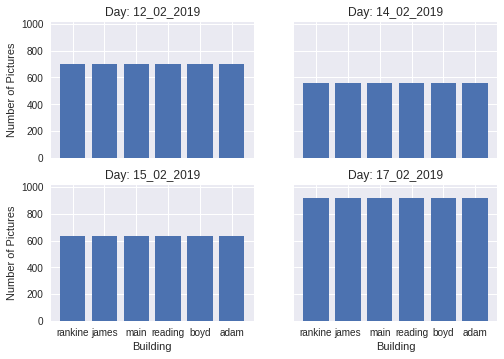

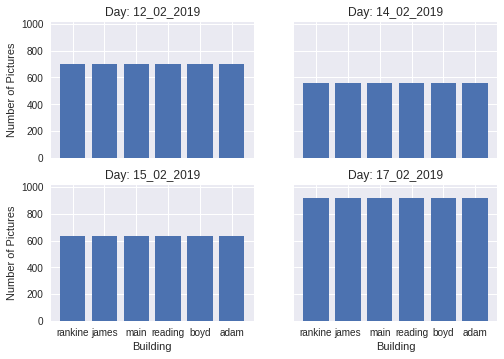

In [49]:
plot_day_distribution(sub_sampled_index, picture_folders, max_y_val)

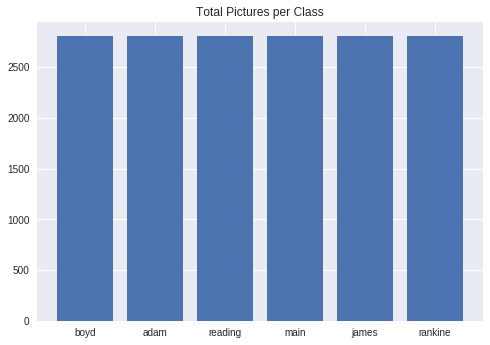

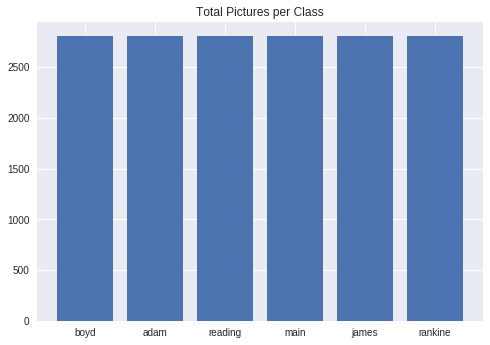

In [50]:
plot_total_distribution(sub_sampled_index)

# Train/Validation/Test Split and Data Generator Setup
As the data was generated from a video, concurrent frames are very similiar. Therefore if the test set is randomly selected then it is very likely the model will be trained on almost identical images giving misleading results.

To solve this the data collected on the 14/02/2019 will be used exclusivly for final evaluation of models as it contains the least number of photos after the sub-sampling process. 

For training the models the remaining data will be used. For validation, 3-fold cross-validation will be used with each fold representing a full day of data.

Train | Test
--|--
12/02/2019 | 14/02/2019
15/02/2019|
17/02/2019|

## Data Generators

In [0]:
'''Based on code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly'''

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, labels, batch_size, dim, n_classes, shuffle):
        """Initialization"""
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle

        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # Store sample
            X[i,] = plt.imread(ID)[:,:,:3]
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [127]:
# used for converting labels to ints
conversion_table = {}
for index, label in enumerate(labels):
    conversion_table[label] = index

conversion_table

{'adam': 5, 'boyd': 4, 'james': 1, 'main': 2, 'rankine': 0, 'reading': 3}

In [0]:
x = plt.imread(partition["train"][0])[:,:,:3]

In [129]:
np.max(x)

0.9882353

In [0]:
tmp = {}
partition = {'train':[], 'validation':[]} # contains list of training and validation ID's
validation_user = "12_02_2019" # use user B for validation

for user_letter, actions in sub_sampled_index.items():
    for action, results in actions.items():
        for result in results:
            if user_letter == validation_user:
                partition["validation"].append(result)
                tmp[result] = conversion_table[action]

            else:
                partition["train"].append(result)
                tmp[result] = conversion_table[action]

In [0]:
test_generator = DataGenerator(partition['train'], tmp, 32, (224,224,3), len(labels), True)

In [0]:
model = Sequential(name="test")


model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1],3), activation='relu'))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(len(labels), activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [134]:
history = model.fit_generator(generator=test_generator,
                    use_multiprocessing=False,
                    workers=1,
                    epochs=5,
                    verbose=1)

Epoch 1/5
395/395 [==============================] - 125s 317ms/step - loss: 1.0014 - acc: 0.5969
Epoch 2/5
395/395 [==============================] - 124s 313ms/step - loss: 0.1134 - acc: 0.9586
Epoch 3/5
395/395 [==============================] - 123s 313ms/step - loss: 0.0677 - acc: 0.9793
Epoch 4/5
395/395 [==============================] - 123s 312ms/step - loss: 0.0225 - acc: 0.9931
Epoch 5/5
395/395 [==============================] - 123s 311ms/step - loss: 0.0298 - acc: 0.9903


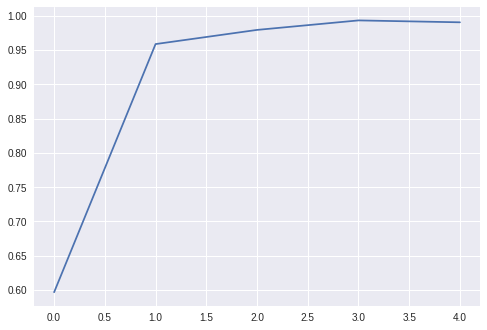

In [135]:
plt.plot(history.history["acc"])

In [0]:
#@title Load the Flowers data set and split into test & train sets [RUN ME]
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)
  
download_images()

!rm ./flower_photos/LICENSE.txt
if not os.path.exists('./flowers'):
    os.mkdir('./flowers')


image_dir = FLOWERS_DIR
from sklearn.model_selection import train_test_split

# Read all flower images (.jpg) from a folder
# The function returns both the path of the flower image and the corresponding label
# which is defined by the name of the foler in which the image is
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    
    labels = []
    images = []
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        labels_folder, images_folder = read_images_from_dir(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_images(image_dir)


# Split the data into test and training sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

# Create folders for test and training that can be passed to Keras Generators
train_folder = './flowers/output/train'
test_folder  = './flowers/output/test'
output_folder = './flowers/output'

def create_output_folders():
    if not os.path.exists(output_folder):
        print('Creating output directories')
        os.mkdir(output_folder)
        if not os.path.exists(train_folder):
            os.mkdir(train_folder)
            for label in set(labels):
                os.mkdir(train_folder + '/' + label)
        if not os.path.exists(test_folder):
            os.mkdir(test_folder)
            for label in set(labels):
                os.mkdir(test_folder + '/' + label)

def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
        dest = os.path.join(train_folder, labels_train[index])
        shutil.copy(value, dest)

    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
        shutil.copy(value, test_folder + '/' + labels_test[index])
        
create_output_folders()
copy_files_to_train_and_validation_folders()

We now create some data generators for working with the flowers data

In [0]:
#images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator      = data_generator.flow_from_directory(train_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(test_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')

Adapt the code below to work with the generators, then proceed with the experiments!

In [0]:
# create the base pre-trained model
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False)

lamb = 0.001

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(YOUR NUMBER OF CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'] )

# train the model on the new data for a few epochs
model.fit_generator(FILL IN YOUR DETAILS...)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(FILL IN YOUR DETAILS...)



*   construction work
*   weather conditions such as fog and snow
*   full perimeter often unavailable due to construction
*   lack of variation in distance (not any images from far away)
*   only one camera used
*   variations in lighting only simualted, no evening images

